# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import inflection 
import plotly.express as p
import umap.umap_ as umap
import re

from matplotlib import pyplot as plt
from IPython.display import HTML
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler


/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.1 Helper Functions

### Set Display

In [2]:
def notebook_settings():

    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [24, 9]
    plt.rcParams['font.size'] = 24

    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns=None
    pd.options.display.max_rows=None
    pd.set_option( 'display.expand_frame_repr', False)

    sns.set()
notebook_settings()

In [3]:
# supress scientific notation
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## 0.2 Load Data

In [4]:
data = pd.read_csv('../data/raw/data.csv', encoding='unicode_escape')

# Planification (IoT)

# 1.0 Data Description

### 1.1 Data Dimensions

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [6]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom


### 1.2 Rename Columns

In [5]:
cols_old = ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country']

snakecase = lambda x: inflection.underscore( x ) # change to snakecase
cols_new = list( map( snakecase, cols_old ))

data.columns = cols_new # define the new columns

### 1.3 Check and fillout Nan

In [6]:
# check Na
data.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

In [6]:
# drop Na
df1 = data.dropna(subset=['description', 'customer_id'])
print('Removed data: {:.2f}'.format(1-(df1.shape[0]/data.shape[0])))

Removed data: 0.25


### 1.4 Change dtypes

In [7]:
# invoice data to datetime
df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.date
#df1['invoice_date'] = df1['invoice_date'].dt.date

# customer id
df1['customer_id'] = df1['customer_id'].astype(int)

/tmp/ipykernel_17015/1837987786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['invoice_date'] = pd.to_datetime(df1['invoice_date']).dt.date
/tmp/ipykernel_17015/1837987786.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['customer_id'] = df1['customer_id'].astype(int)


### 1.5 Descriptive Statistics

In [35]:
num_att = df1.select_dtypes(include=['int64', 'float64'])
cat_att = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'])

#### Numerical

In [36]:
# central tendency - mean and median
mean = pd.DataFrame(num_att.apply( np.mean )).T
median = pd.DataFrame(num_att.apply( np.median )).T

# dispertion - std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_att.apply( np.std )).T
min_ = pd.DataFrame(num_att.apply( np.min )).T
max_ = pd.DataFrame(num_att.apply( np. max )).T
range_ = pd.DataFrame(num_att.apply( lambda x: x.max() - x.min())).T
skew = pd.DataFrame(num_att.apply( lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_att.apply( lambda x: x.kurtosis())).T

# concatenate
description = pd.concat([mean, median, std, min_, max_, range_, skew, kurtosis]).T.reset_index()
description.columns = ['index', 'mean', 'median', 'std', 'min', 'max', 'range', 'skew', 'kurtosis']


In [37]:
description

,index,mean,median,std,min,max,range,skew,kurtosis
0,quantity,12.061,5.000,248.693,-80995.000,80995.000,161990.000,0.183,94317.564
1,unit_price,3.460,1.950,69.315,0.000,38970.000,38970.000,452.219,246924.543
2,customer_id,15287.691,15152.000,1713.598,12346.000,18287.000,5941.000,0.030,-1.180


#### Categorical

In [52]:
# invoice number

# There are some 'invoice_no' that starts with a 'C', and the number matchs with the number of quantities < 0.
# I will supose that 'C' represents orders that was returned

invoice_letter = df1[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]', x)))]
print(f'Nº of invoice with a letter: {invoice_letter.shape[0]}')
print(f'Nº of quantity < 0: {df1[df1["quantity"] < 0].shape[0]}')

Nº of invoice with a letter: 8905
Nº of quantity < 0: 8905


In [61]:
# Stock code

# Action
# remove stock_code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']

only_str_stock = df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code']
print(f'Only String Stock code: {only_str_stock.shape[0]}')


Only String Stock code: 1774


In [62]:
# Description

df1.head()

# Action
# Delete description column

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.550,17850.000,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.750,17850.000,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.390,17850.000,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.390,17850.000,United Kingdom


In [66]:
# Country

# nº invoice_no by country
by_country = df1[['invoice_no', 'country']].groupby('country').count().reset_index()
by_country['%'] = by_country['invoice_no'].apply( lambda x: 100 * (x / df1.shape[0]))
by_country.sort_values('invoice_no', ascending=False)

,country,invoice_no,%
35,United Kingdom,361878,88.951
14,Germany,9495,2.334
13,France,8491,2.087
10,EIRE,7485,1.840
30,Spain,2533,0.623
23,Netherlands,2371,0.583
3,Belgium,2069,0.509
32,Switzerland,1877,0.461
26,Portugal,1480,0.364
0,Australia,1259,0.309


In [74]:
# total revenue by country
rev = df1[['quantity', 'unit_price', 'country']]
rev['total'] = rev['quantity'] * rev['unit_price']

rev_by_country = rev[['country', 'total']].groupby('country').sum().reset_index()
rev_by_country['%'] = rev_by_country['total'].apply(lambda x: 100 * (x/sum(rev_by_country['total']))) 
rev_by_country.sort_values('total', ascending=False)

/tmp/ipykernel_7296/699374305.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rev['total'] = rev['quantity'] * rev['unit_price']


,country,total,%
35,United Kingdom,6767873.394,81.540
23,Netherlands,284661.540,3.430
10,EIRE,250285.220,3.015
14,Germany,221698.210,2.671
13,France,196712.840,2.370
0,Australia,137077.270,1.652
32,Switzerland,55739.400,0.672
30,Spain,54774.580,0.660
3,Belgium,40910.960,0.493
31,Sweden,36595.910,0.441


# 2.0 Filtragem de variáveis

In [22]:
df2 = df1.copy()

In [23]:
# unit price > 0.010
df2 = df2.loc[df2['unit_price'] > 0.010, :]

# stock code 
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'M', 'DOT', 'CRUK', 'C2'])]

# description
df2 = df2.drop(columns='description', axis=1)

#map
df2 = df2[~df2['country'].isin(['European Community', 'Unspecified'])]


## quantity - negative numbers means product returns
df2_returns = df2.loc[df2['quantity'] < 0, :]
df2 = df2.loc[df2['quantity'] > 0, :]

# 3.0 Feature Engineering

In [24]:
# date reference 
df_ref = df2.drop(['invoice_no', 'stock_code',
                   'quantity', 'invoice_date', 'unit_price', 
                   'country'], axis=1).drop_duplicates(ignore_index=True)

In [25]:
df_ref.head()

,customer_id
0,17850
1,13047
2,12583
3,13748
4,15100


In [26]:
# Gross revenue (quantity * price)
df2['revenue'] = df2['unit_price'] * df2['quantity']

# Monetery
monetary = df2[['customer_id', 'revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, monetary, on='customer_id', how='left')

# Recency (the last purchase)
recency = df2[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
recency['recency_days'] = (df2['invoice_date'].max() - recency['invoice_date']).apply(lambda x: x.days)
recency = recency[['customer_id', 'recency_days']]
df_ref = pd.merge(df_ref, recency, on='customer_id', how='left')

# Frequency 
frequency = df2[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
frequency.columns = ['customer_id', 'frequency']
df_ref = pd.merge(df_ref, frequency, on='customer_id', how='left')

# Avg Ticket
avg_ticket = df2[['customer_id', 'revenue']].groupby('customer_id').mean().reset_index().rename(columns={'revenue': 'avg_ticket'})
df_ref = pd.merge(df_ref, avg_ticket, on='customer_id', how='left')

# number of returns
df_returns = df2_returns[['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index().rename(columns={'invoice_no':'returns'})
df_ref = pd.merge(df_ref, df_returns, how='left', on='customer_id')
df_ref = df_ref.fillna(0)
df_ref['returns'] = df_ref['returns'].astype(int)

In [27]:
df_ref.head()

,customer_id,revenue,recency_days,frequency,avg_ticket,returns
0,17850,5391.210,372,34,18.152,1
1,13047,3232.590,56,9,18.904,7
2,12583,6705.380,2,15,28.902,2
3,13748,948.250,95,5,33.866,0
4,15100,876.000,333,3,292.000,3


# 4.0 EDA

## 4.1 Hypothesis Map

## 4.2 Univariate Analysis

# 5.0 Data Preparation

In [46]:
df3 = df_ref.copy()

In [47]:
# standart scaler
ss = StandardScaler()

# revenue
df3['revenue'] = ss.fit_transform(df3[['revenue']])
# revenue
df3['recency_days'] = ss.fit_transform(df3[['recency_days']])
# revenue
df3['frequency'] = ss.fit_transform(df3[['frequency']])
# revenue
df3['avg_ticket'] = ss.fit_transform(df3[['avg_ticket']])
# revenue
df3['returns'] = ss.fit_transform(df3[['returns']])

In [48]:
df3.head()

,customer_id,revenue,recency_days,frequency,avg_ticket,returns
0,17850,0.378,2.792,3.893,-0.034,0.115
1,13047,0.136,-0.361,0.622,-0.033,3.158
2,12583,0.526,-0.900,1.407,-0.027,0.622
3,13748,-0.121,0.028,0.098,-0.023,-0.393
4,15100,-0.129,2.402,-0.164,0.152,1.129


# 6.0 Feature Selection

## 6.1 Split Train & Validation

## 6.2 Fature Selection

### Boruta

### Fature Importance

# 7.0 Hyperparameter Fine-Tunning

In [51]:
df4 = df3.copy()
X = df4.drop( columns=['customer_id'])

In [52]:
cluster = [2, 3, 4, 5, 6, 7, 8, 9, 10]

### Within-Cluster Sum of Squares (WSS)

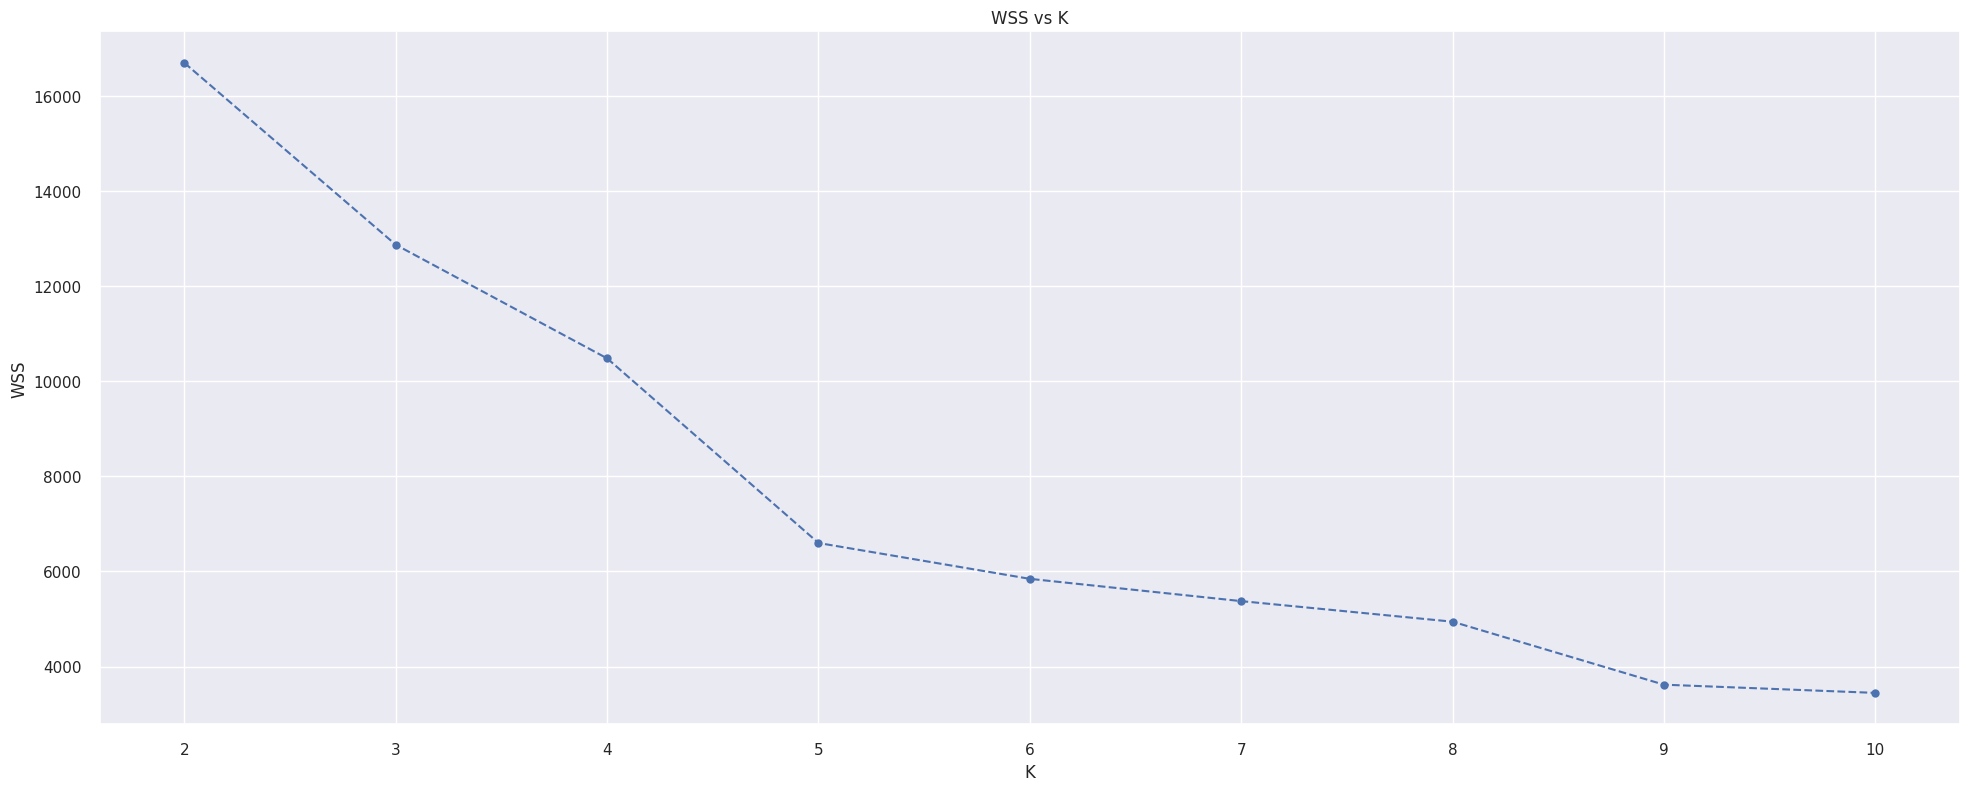

In [53]:
wss = []
for k in cluster:
    # model definition
    kmeans = KMeans(init='random', n_clusters=k, n_init=10,  max_iter=300, random_state=42)

    # model training
    kmeans.fit( X )

    #validation
    wss.append(kmeans.inertia_)

# plot wss - Elbow Method
plt.plot(cluster, wss, linestyle='--', marker='o');
plt.xlabel( 'K' );
plt.ylabel( 'WSS' );
plt.title('WSS vs K');

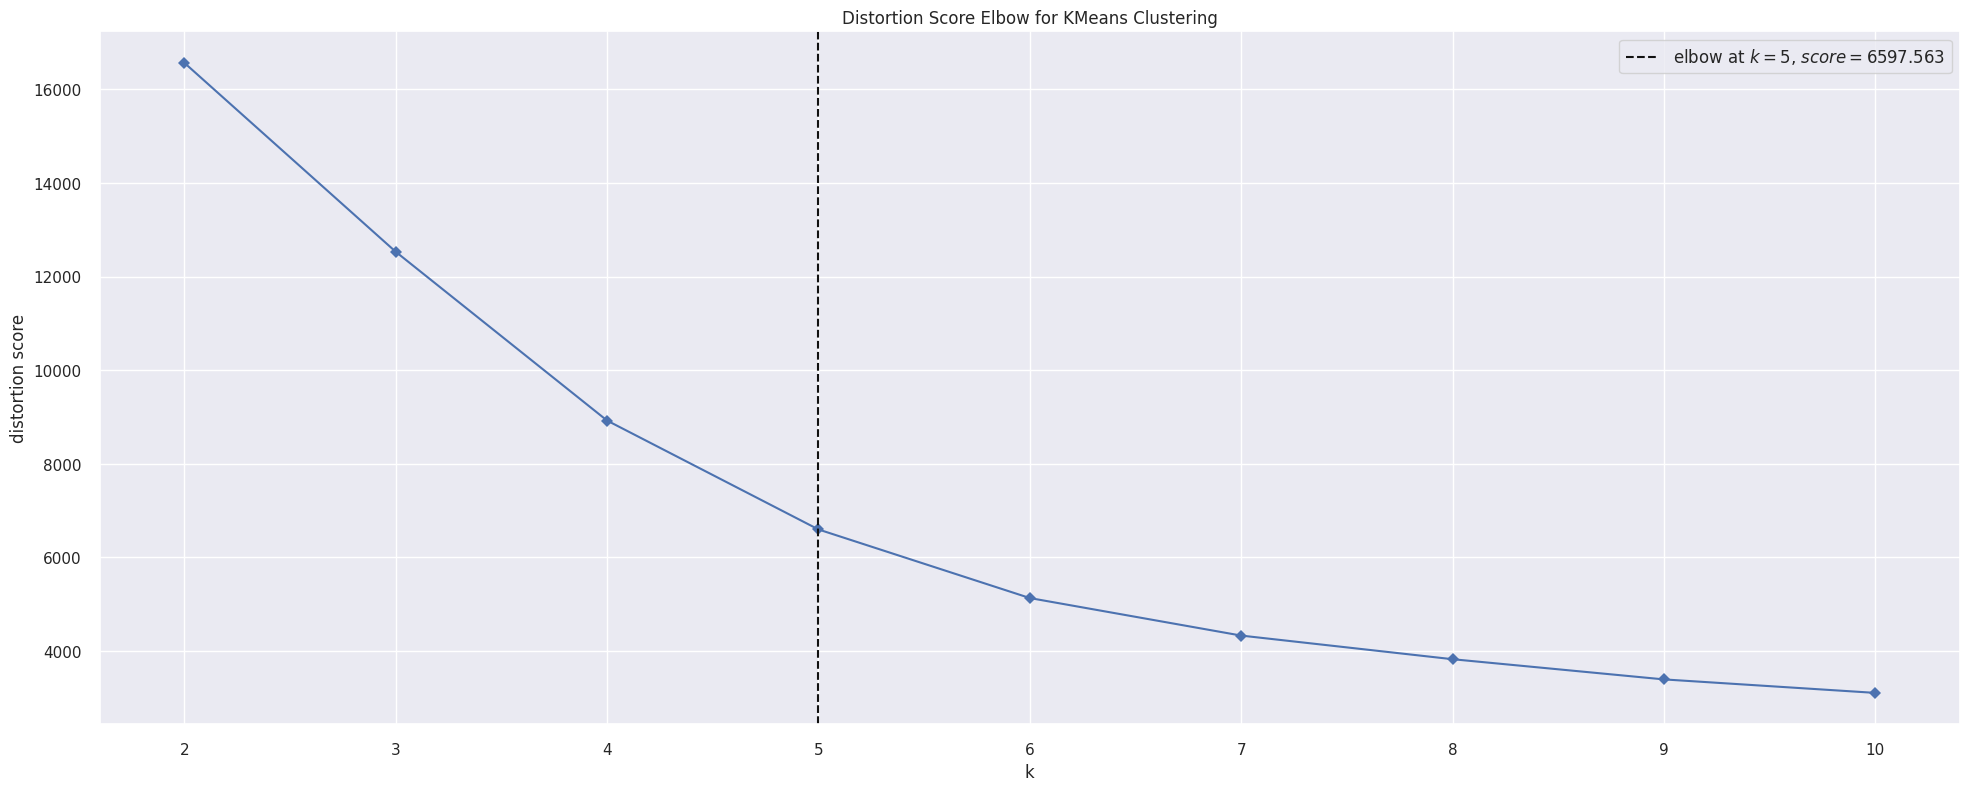

In [54]:
# yellowbrick library
kmeans = KElbowVisualizer( KMeans(n_init=10), k=cluster, timings=False)
kmeans.fit( X );
kmeans.show();

### Silhouette Score

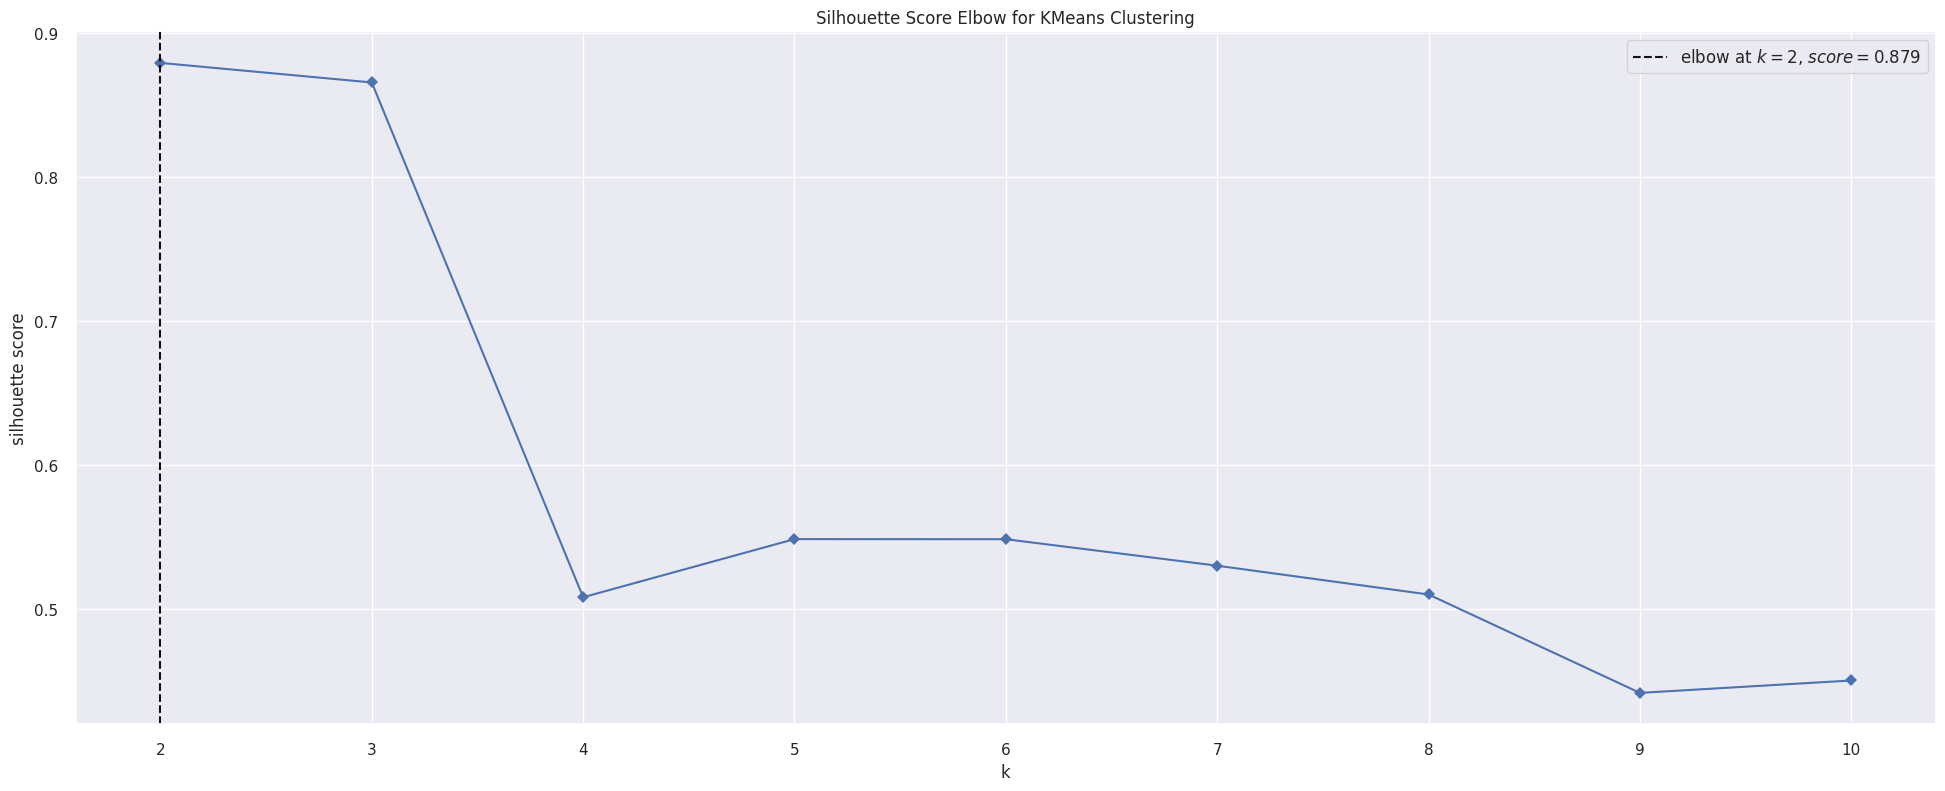

In [55]:
kmenas = KElbowVisualizer( KMeans(n_init=10), k=cluster, metric='silhouette', timings=False);
kmenas.fit( X );
kmenas.show();

### Silhouette Analysis

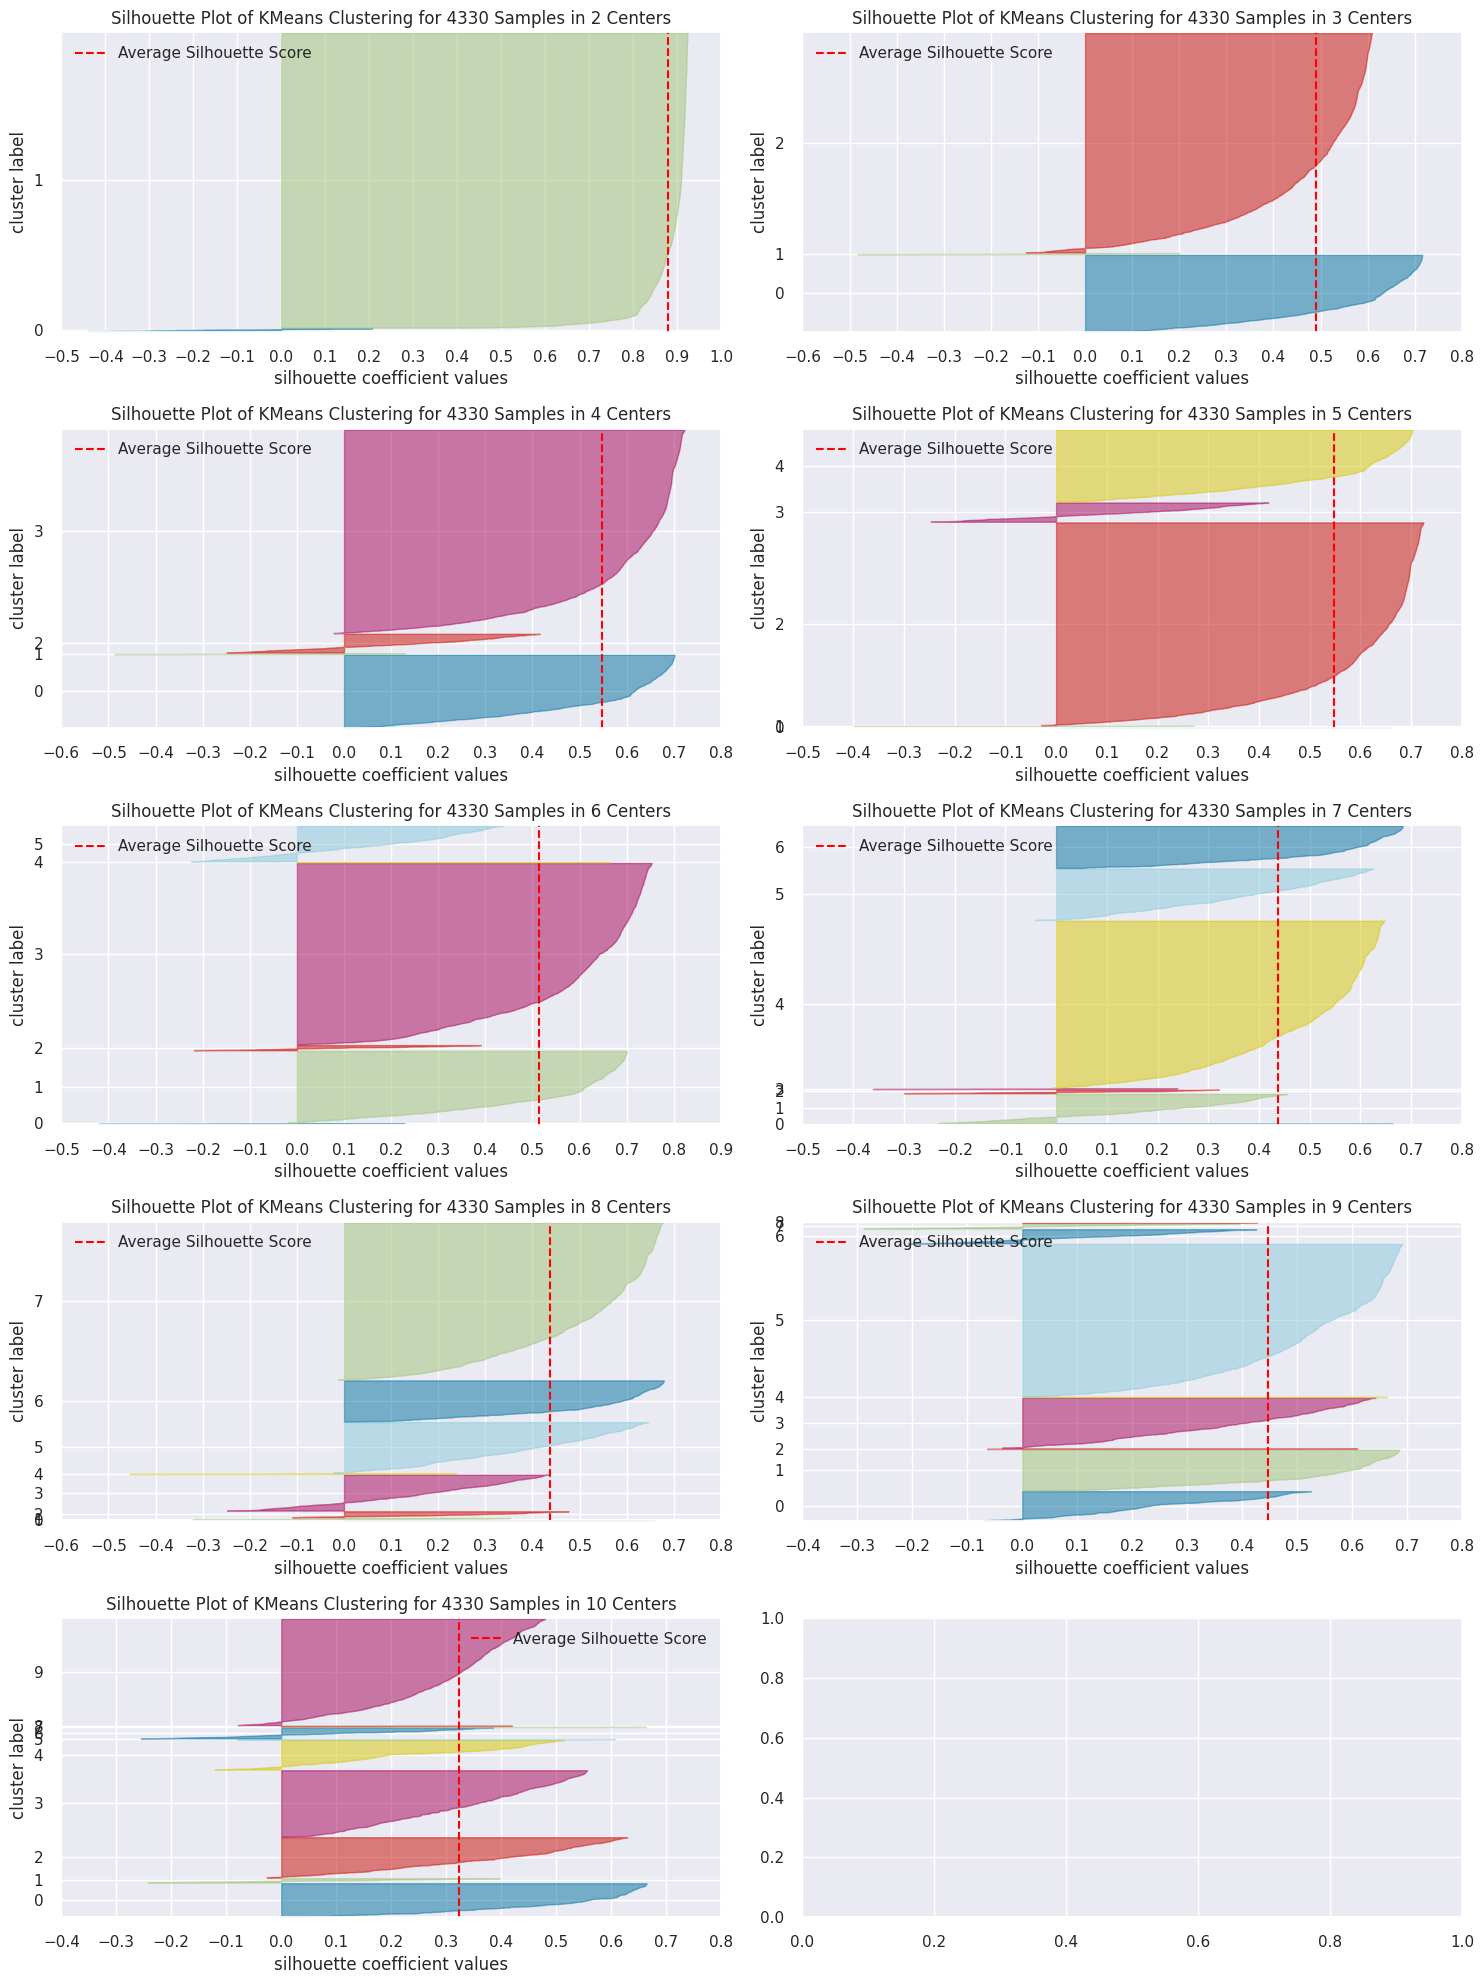

In [56]:
fig, ax = plt.subplots(5, 2, figsize=(15,20))

for k in cluster:
    km = KMeans(n_clusters=k, init='random', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod( k - 2, 2)

    viz = SilhouetteVisualizer( km, colors='yellowbrick', ax=ax[q][mod])
    viz.fit( X )
    viz.finalize()

plt.tight_layout()
plt.show()

# 8.0 Machine Learnign Modeling

In [57]:
# model definition
k = 3
kmeans = KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=42)

# model trainig 
kmeans.fit ( X )

# clustering
labels = kmeans.labels_

### Cluster Validation

In [58]:
# WSS 
print( f'WSS value: {kmeans.inertia_}')

# Silhouette
print(f'SS Value: {metrics.silhouette_score( X, labels, metric="euclidean")}')

WSS value: 12868.40922785506


SS Value: 0.49061154578700705


In [17]:
# WSS 
print( f'WSS value: {kmeans.inertia_}')

# Silhouette
print(f'SS Value: {metrics.silhouette_score( X, labels, metric="euclidean")}')

WSS value: 105730502002.71082


SS Value: 0.9493720768936347


# 9.0 Cluster Analysis

In [59]:
df5 = df_ref.copy()
df5['cluster'] = labels

### 2D Plot

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be r

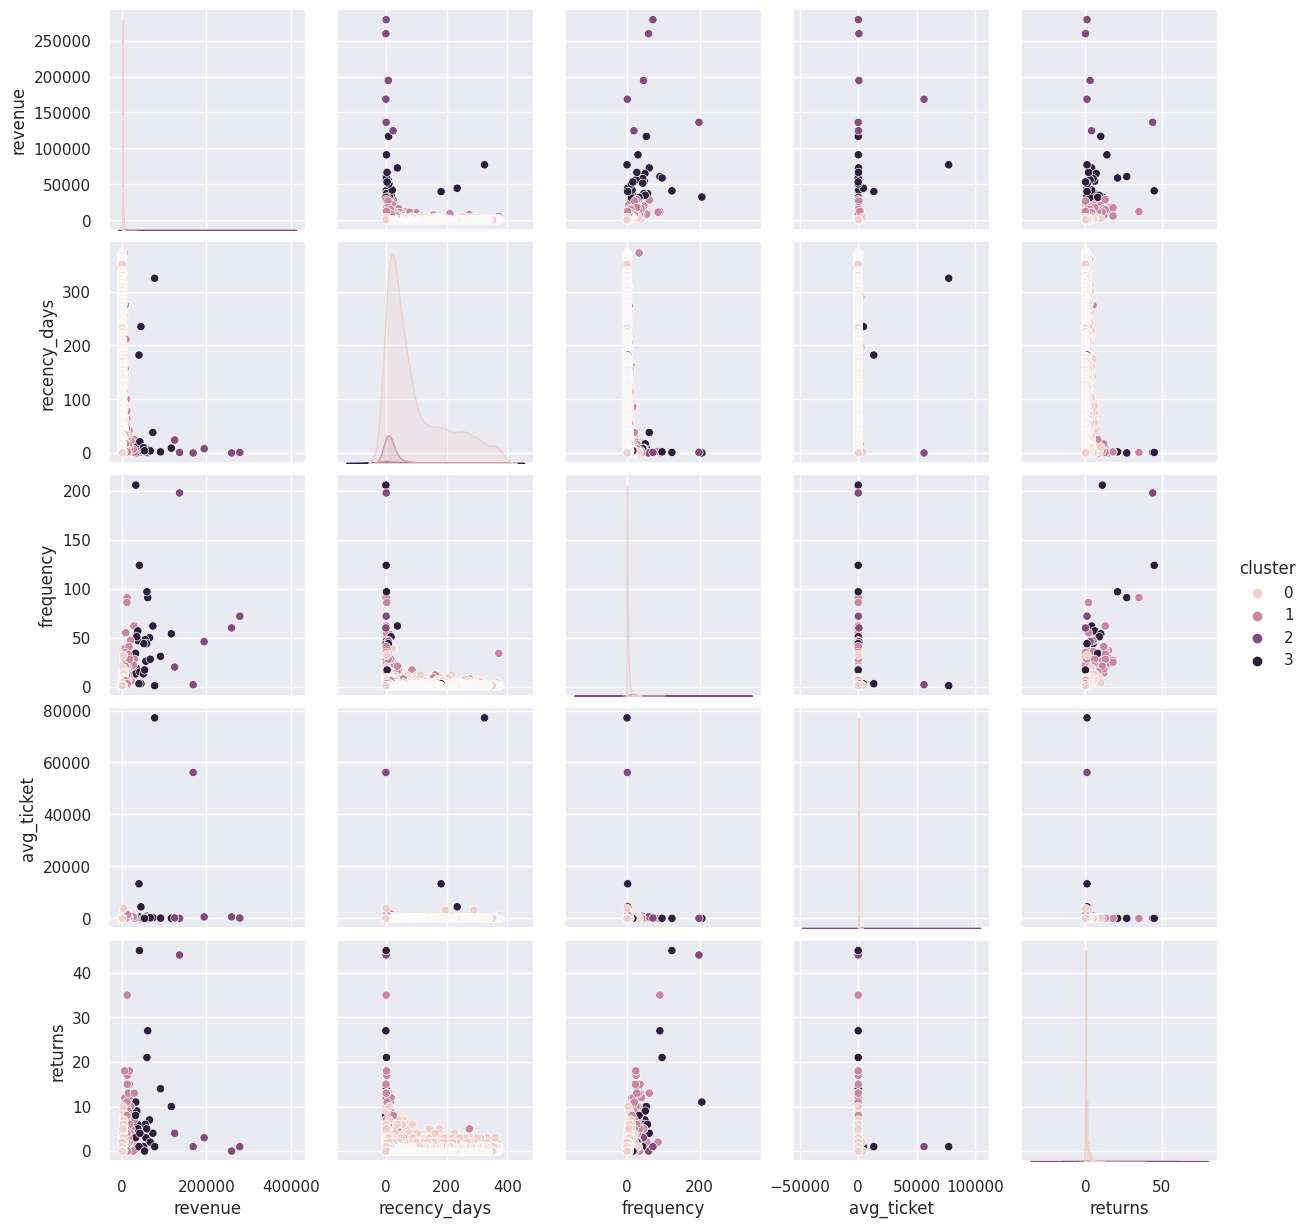

In [40]:
df_viz = df5.drop(columns='customer_id', axis=1)
sns.pairplot(df_viz, hue='cluster')

### Visualization Inspection

In [73]:
df3.head()

,customer_id,revenue,recency_days,frequency,avg_ticket,cluster
0,17850,5288.630,302,35,16.951,4
1,13047,3079.100,31,18,15.710,3
2,12583,7187.340,2,18,28.635,4
3,13748,948.250,95,5,33.866,3
4,15100,635.100,330,6,105.850,3


In [59]:
# 3 clusters and without avg ticket
fig = px.scatter_3d(df3, x='recency_days', y='frequency', z='revenue', color='cluster')
fig.show()

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


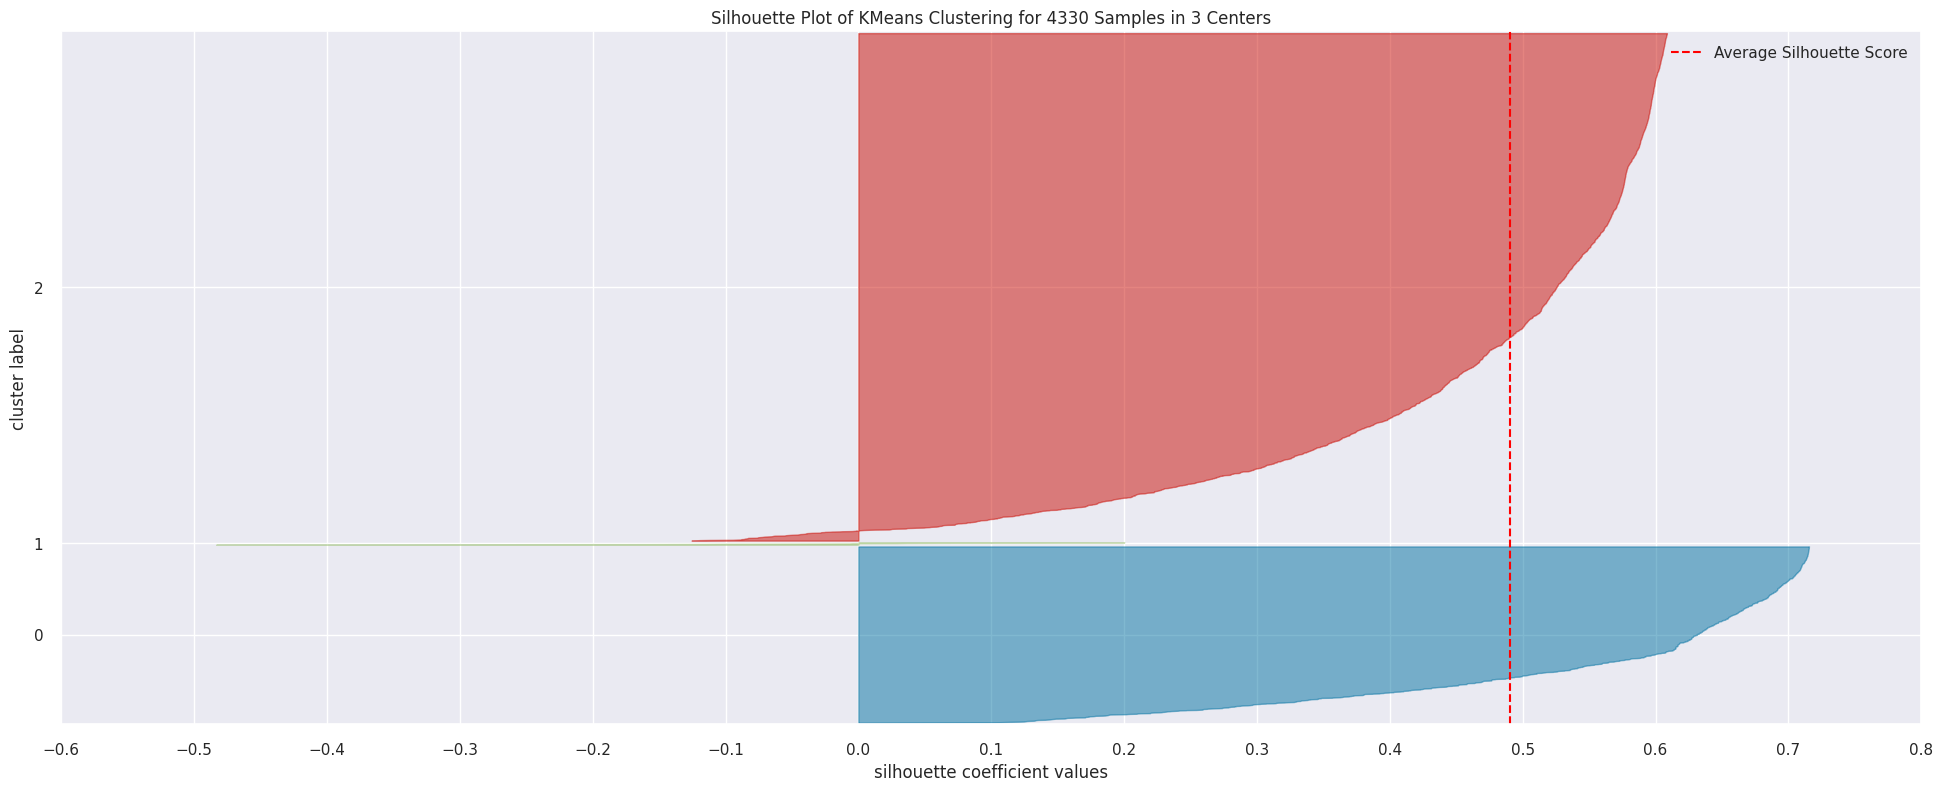

In [60]:
# 4 Clusters with avg ticket
viz = SilhouetteVisualizer( kmeans, colors='yellowbrick')
viz.fit( X )
viz.finalize()

### UMAP - t-SNE (Manifold)

/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/natan/miniconda3/envs/clusterenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

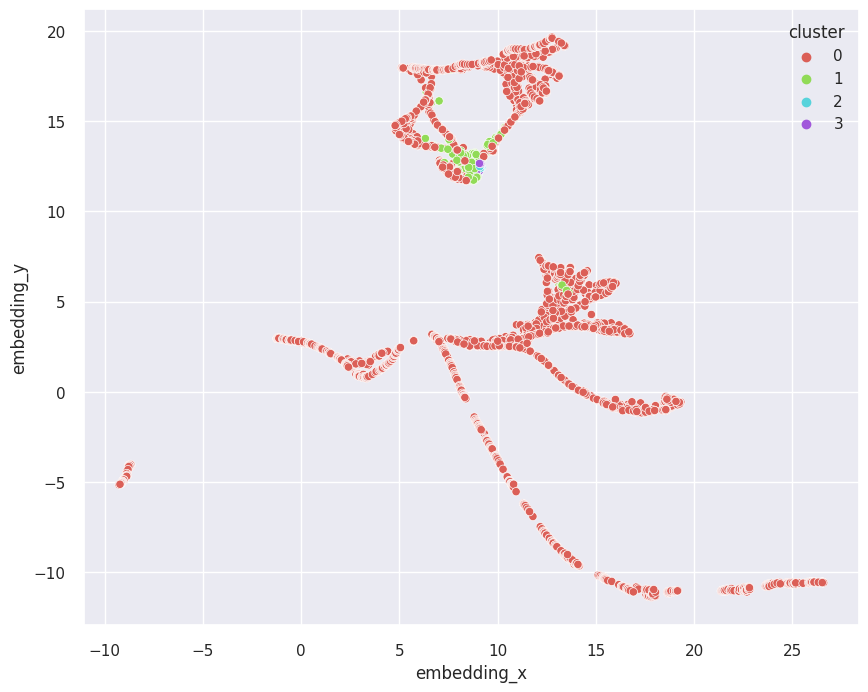

In [62]:
reducer = umap.UMAP( n_neighbors=50, random_state=42 )
embedding = reducer.fit_transform( X )

# embedding
df_viz['embedding_x'] = embedding[:, 0]
df_viz['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(10,8))
sns.scatterplot(x='embedding_x', y='embedding_y', 
                data=df_viz, 
                hue='cluster', 
                palette=sns.color_palette( 'hls', n_colors=len(df_viz['cluster'].unique())))

### Cluster Profile

In [63]:
# Number of customers
df_cluster = df5[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['per_customer'] = 100 * df_cluster['customer_id'] / df_cluster['customer_id'].sum()

# Avg revenue
df_avg_revenue = df5[['revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_revenue, on='cluster', how='inner')

# Avg recency
df_avg_recency = df5[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_recency, on='cluster', how='inner')

# Avg frequency
df_avg_frequency = df5[['frequency', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_frequency, on='cluster', how='inner')

# Avg Ticket
df_avg_ticket = df5[['avg_ticket', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, df_avg_ticket, on='cluster', how='inner')

In [64]:
df_cluster

,cluster,customer_id,per_customer,revenue,recency_days,frequency,avg_ticket
0,0,1113,25.704,548.516,243.650,1.571,54.732
1,1,16,0.370,111903.538,25.938,75.312,8470.358
2,2,3201,73.926,1985.770,39.852,4.826,30.621


# 10.0 Deploy